In [9]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import missingno as msno
from scipy.stats import ks_2samp
import yaml
import shap
import random
from lightgbm import LGBMClassifier

from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, auc, f1_score
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import plotly.express as px
import plotly
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

sns.set(rc={'axes.facecolor':'#fafafa', 'figure.facecolor':'#fafafa'})
plt.rcParams['axes.facecolor']='#fafafa'
plt.rcParams['savefig.facecolor']='#fafafa'

import utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Color Palette

In [10]:
COLOR_FEMALE = '#66c2a5'
COLOR_MALE = '#fc8d62'
COLOR_OTHER = '#808080'
colors = [COLOR_FEMALE, COLOR_MALE, COLOR_OTHER]

palette = sns.color_palette(colors, 3)
palette

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5019607843137255, 0.5019607843137255, 0.5019607843137255)]

## Loading Data

In [11]:
df = utils.load_data('sex-role')
questions = utils.load_questions('sex-role')
questions_dict = utils.load_questions('sex-role', as_series=False)

In [12]:
df.gender.value_counts()

2    156267
1    131930
3     25951
0      4425
Name: gender, dtype: int64

# Preprocessing

Columns description

**age** "What is your age?", entered as text

**gender** 1=Male, 2=Female, 3=Other

**accuracy** How sure are you of your response?

In [13]:
df.gender = df.gender.map({1: 'Male', 2: 'Female', 3: 'Other'})

# removing impossble values, such as negative and higher than a normal human life span
df.age = df.age.clip(12, 80)

#df.drop(['EQ', 'SQ'], axis=1, inplace=True)

In [14]:
# defining gender columns and converting to int
QUESTION_COLS = [col for col in df.columns if col.startswith(('Q'))]
NON_QUESTION_COLS = [col for col in df.columns if col not in QUESTION_COLS]

df[QUESTION_COLS] = df[QUESTION_COLS].astype(int)

In [15]:
# remove respondents with no gender specified
no_gender_specified_pct = np.round(df[df.gender.isnull()].shape[0] / df.shape[0] * 100,2)
print(f'Persons with no gender specified: {no_gender_specified_pct}%')
df = df[df.gender.notnull()]

Persons with no gender specified: 1.39%


In [16]:
# Mappping answers to a description
# we are treating strongly agree/disagree same as agree/disagree, respectively
for col in QUESTION_COLS:
    df[col] = df[col].map({1: 'Disagree', 2: 'Disagree', 3: 'No Answer', 
                           4: 'Agree', 5: 'Agree'}).astype("category")

In [17]:
df.gender.unique()

array(['Female', 'Male', 'Other'], dtype=object)

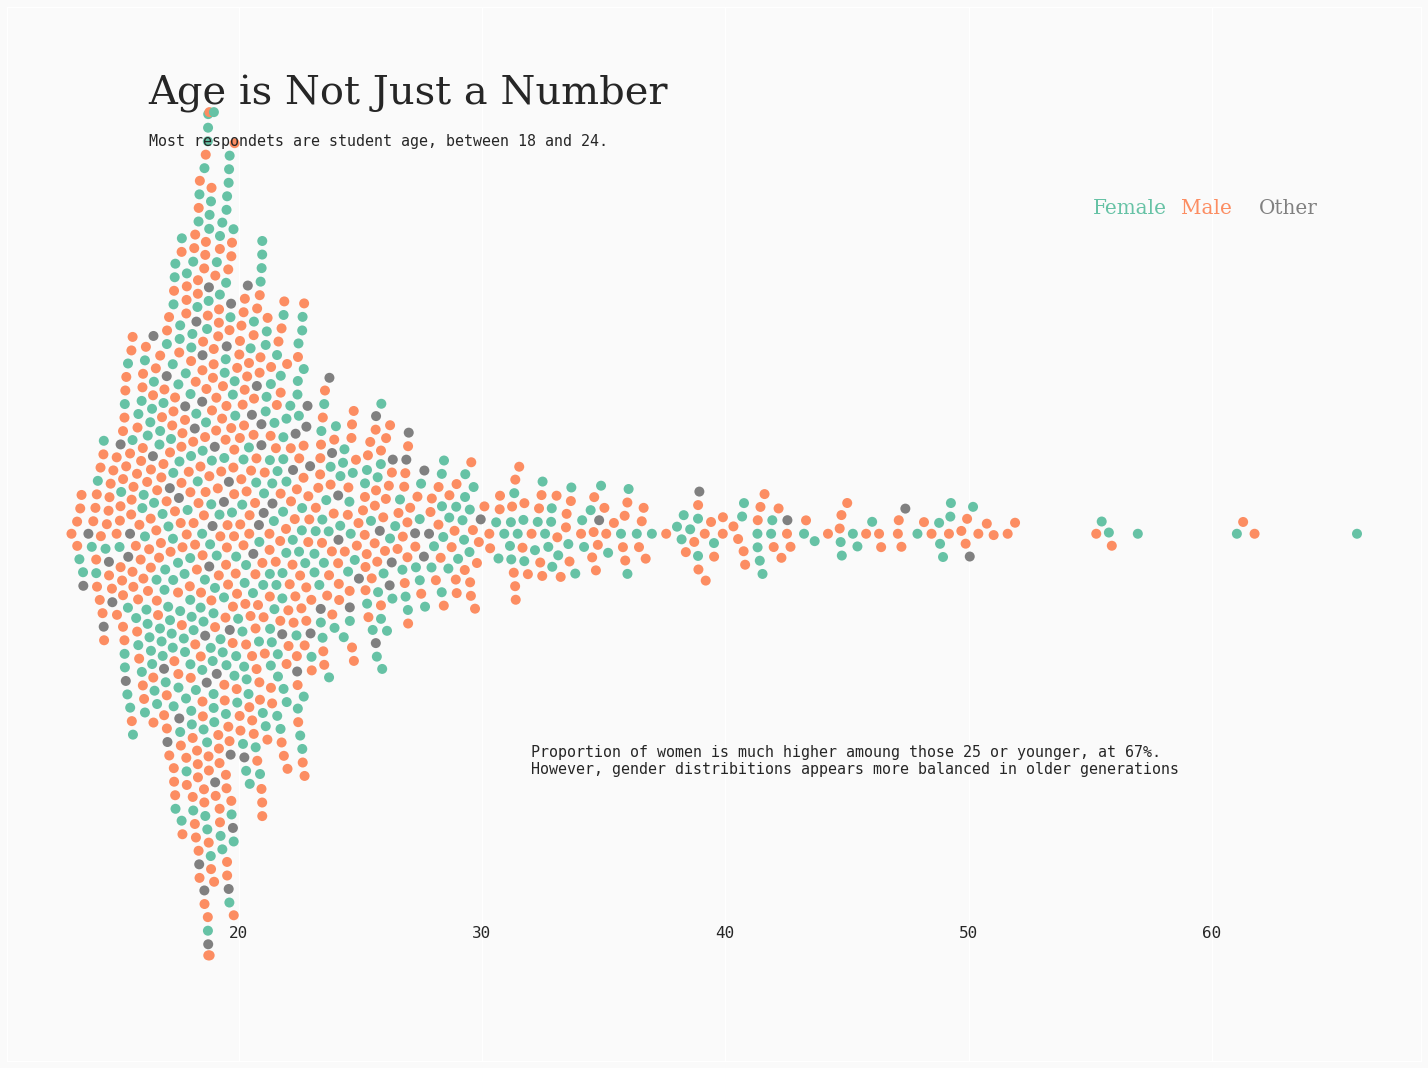

In [18]:
SAMPLE_SIZE = 1000

# add some tiny noisiness for better visualization
df['age_noisy'] = df.age.apply(lambda x: x + random.uniform(0, 1))


fig, ax = plt.subplots(1,1, figsize=(20,15))
ax.set_facecolor('#fafafa')
sns.swarmplot(x='age_noisy', y=['']*SAMPLE_SIZE, 
              hue='gender', data=df.sample(SAMPLE_SIZE),
              dodge=False, size=10, ax=ax,
             palette=palette)

ax.annotate('Age is Not Just a Number', xy=(50, 0),  xycoords='data',
            xytext=(0.1, 0.9), textcoords='axes fraction',
            horizontalalignment='left', verticalalignment='bottom',
            fontsize=40, fontfamily='serif'
            )
ax.annotate('Most respondets are student age, between 18 and 24.', xy=(50, 0),  xycoords='data',
            xytext=(0.1, 0.88), textcoords='axes fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=15, fontfamily='monospace'
            )
ax.annotate('Proportion of women is much higher amoung those 25 or younger, at 67%.\nHowever, gender distribitions appears more balanced in older generations', xy=(50, 0),  xycoords='data',
            xytext=(32, 0.2),
            horizontalalignment='left', verticalalignment='top',
            fontsize=15, fontfamily='monospace'
            )

# legend
ax.annotate('Male', xy=(50, 0),  xycoords='data',
            xytext=(0.83, 0.8), textcoords='axes fraction',
            horizontalalignment='left', verticalalignment='bottom',
            fontsize=20, fontfamily='serif', color=COLOR_MALE
            )
ax.annotate('Female', xy=(50, 0),  xycoords='data',
            xytext=(0.82, 0.8), textcoords='axes fraction',
            horizontalalignment='right', verticalalignment='bottom',
            fontsize=20, fontfamily='serif', color=COLOR_FEMALE
            )
ax.annotate('Other', xy=(50, 0),  xycoords='data',
            xytext=(0.885, 0.8), textcoords='axes fraction',
            horizontalalignment='left', verticalalignment='bottom',
            fontsize=20, fontfamily='serif', color=COLOR_OTHER
            )

ax.set_xlabel('')
ax.get_legend().remove()
ax.tick_params(axis="x",direction="in", pad=-135)
plt.xticks(fontsize=16, fontfamily='monospace')
plt.tight_layout()

In [19]:
def format_title(title):
    if len(title) > 40:
        words = title.split(' ')
        num_words = int(len(words) / 2)
        return ' '.join(words[:num_words])+'\n' + ' '.join(words[num_words:])
    else:
        return title
    
print(format_title(questions_dict['Q13']))

I would prefer a class in
mathematics to a class in pottery.


In [20]:
questions

Q1                I have studied how to win at gambling.
Q10                   I am happiest when I am in my bed.
Q11                  I did not work very hard in school.
Q12                            I use lotion on my hands.
Q13    I would prefer a class in mathematics to a cla...
Q14                             I dance when I am alone.
Q15    I have thought it would be exciting to be an o...
Q16    When I was a child, I put on fake concerts and...
Q17              I have considered joining the military.
Q18                 I get dizzy when I stand up sharply.
Q19    I do not think it is normal to get emotionally...
Q2                   I have thought about dying my hair.
Q20       I sometimes feel like crying when I get angry.
Q21                         I do not remember birthdays.
Q22                            I save the letters I get.
Q23                       I playfully insult my friends.
Q24       I oppose medical experimentation with animals.
Q25         I could do an impre

In [23]:
def sort_questions(data):
    sorted_questions = data.index.tolist()
    sorted_questions = {q_str:int(q_str[1:]) for q_str in sorted_questions}
    sorted_questions = sorted(sorted_questions.items(), key=lambda item: item[1])
    sorted_questions = [i[0] for i in sorted_questions]
    return sorted_questions

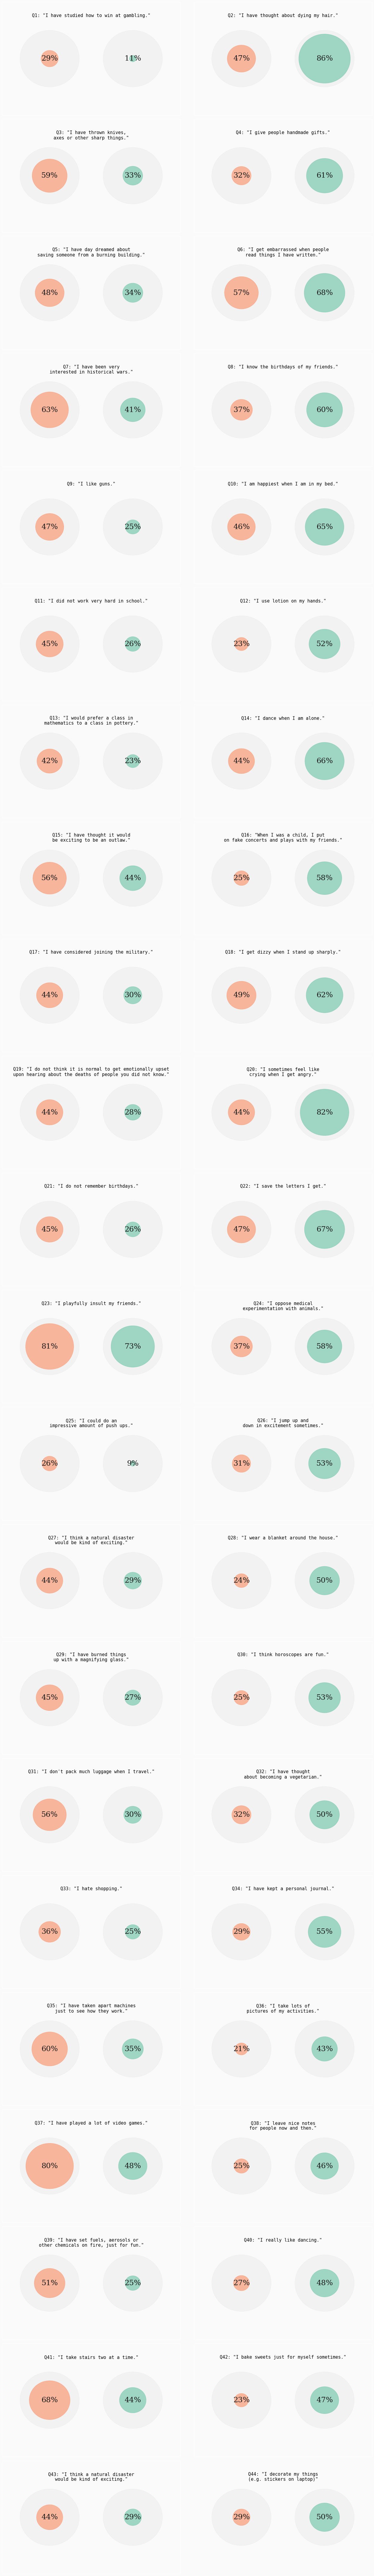

In [22]:
def flatten(t):
    return [item for sublist in t for item in sublist]

data_pct_agree = df[df.gender != 'Other']\
    .applymap(lambda x: 1 if x in ['Agree', 'Female'] else 0)\
    .groupby('gender')\
    .apply(lambda gr: gr.sum() / len(gr))[QUESTION_COLS].T
data_pct_agree.columns = ['Male', 'Female']
data_pct_agree['male_minus_female'] = data_pct_agree.Male - data_pct_agree.Female
data_pct_agree = data_pct_agree.abs().sort_values(by='male_minus_female').iloc[::-1]
data_pct_agree.drop('male_minus_female', axis=1, inplace=True)
sorted_questions = sort_questions(data_pct_agree)
data_pct_agree = data_pct_agree.reindex(sorted_questions)

DIAMETER = 10
RADIUS = DIAMETER / 4
    
def plot_question(question, ax, data):

    # men
    m_coord = (4, 5)
    circle_m_base = plt.Circle((4, 5), RADIUS, color='lightgrey', alpha=0.2)
    circle_m_pct = plt.Circle((4, 5), RADIUS * data.Male, color=COLOR_MALE, alpha=0.6)

    # women
    w_coord = (11, 5)
    circle_w_base = plt.Circle((11, 5), RADIUS, color='lightgrey', alpha=0.2)
    circle_w_pct = plt.Circle((11, 5), RADIUS * data.Female, color=COLOR_FEMALE, alpha=0.6)


    ax.set_xlim([0, 15])
    ax.set_ylim([0, DIAMETER])
    ax.set_facecolor('#fafafa')
    ax.add_patch(circle_m_base)
    ax.add_patch(circle_m_pct)
    ax.add_patch(circle_w_base)
    ax.add_patch(circle_w_pct)

    ax.annotate(str(int(data.Male*100))+'%',
                xy=m_coord, xytext=m_coord,
                horizontalalignment='center', verticalalignment='center',
                fontsize=25, fontfamily='serif', color='k'
                )
    ax.annotate(str(int(data.Female*100))+'%',
                xy=w_coord, xytext=w_coord,
                horizontalalignment='center', verticalalignment='center',
                fontsize=25, fontfamily='serif', color='k'
                )

    ax.annotate(f'{question}: "{format_title(questions_dict[question])}"',
                    xy=(7.5,9),
                    horizontalalignment='center', verticalalignment='top',
                    fontsize=15, fontfamily='monospace', color='black'
                    )
    ax.set_xticks([])
    ax.set_yticks([])

    return ax

fig, axs = plt.subplots(22, 2, figsize=(18,120))
for (question, data), ax in zip(data_pct_agree.iterrows(), flatten(axs)):
    plot_question(question, ax, data)
plt.grid(False)
plt.axis('off')
plt.tight_layout()
plt.savefig('../figures/question-answers.svg', format='svg')

# Modelling: Predicting gender

In [24]:
data = df.query('gender != "Other"').copy()

In [25]:
data['is_female'] = (data.gender == 'Female').astype(int)
data = data.drop(['gender'], axis=1)

In [26]:
data.is_female.sum() / data.shape[0]

0.5422228545057721

In [27]:
len(data.columns) - 1

57

In [28]:
Y_LABEL= 'is_female'
DEMOGRAPHICS_COLS = ['age', 'education', 'orientation', 'race', 'religion']
temp1 = data[[*QUESTION_COLS, *DEMOGRAPHICS_COLS, 'is_female']]#.iloc[:100000]

y = temp1[Y_LABEL]
X = temp1.drop(Y_LABEL, axis=1)#.applymap(lambda x: 1 if x == 'Agree' else 0)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y)

In [29]:
lgbm = LGBMClassifier(max_depth=10, colsample_bytree=0.7)
models = [lgbm]

In [30]:
for model in tqdm(models):
    model.fit(X_train, y_train)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.01s/it]


In [31]:
results = pd.DataFrame({'actuals': y_test})
metrics = dict()

for model in tqdm(models):
    results[f'preds_{model.__class__.__name__}'] = model.predict_proba(X_test)[:, 1]
    preds = (results[f'preds_{model.__class__.__name__}'] >= 0.50).astype(int)
    metrics[model.__class__.__name__] = dict()
    for metric in [precision_score, recall_score, roc_auc_score, accuracy_score, f1_score]:
        metrics[model.__class__.__name__][metric.__name__] = metric(results.actuals, preds)
        
metrics = pd.DataFrame(metrics).T
metrics

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


,accuracy_score,f1_score,precision_score,recall_score,roc_auc_score
LGBMClassifier,0.839122,0.855143,0.835475,0.87576,0.835742


In [32]:
# non-binary
data_nb = df[df.gender == 'Other'].copy().drop('gender', axis=1)\
    [[*QUESTION_COLS, *DEMOGRAPHICS_COLS]]
preds_nb = model.predict_proba(data_nb)[:, 1]

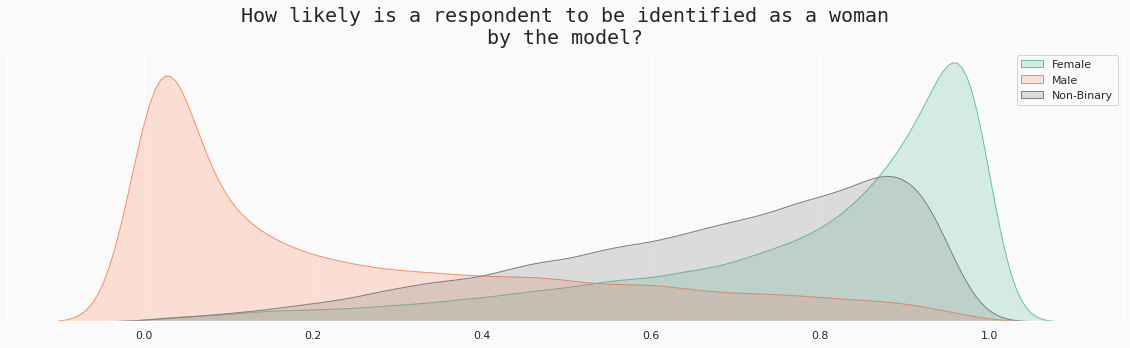

In [33]:
data_women = results.query('actuals == 1').preds_LGBMClassifier
data_men = results.query('actuals == 0').preds_LGBMClassifier

fig, ax = plt.subplots(1, 1, figsize=(20,5))
ax.set_facecolor('#fafafa')
sns.kdeplot(data_women, fill=True, label='Female', ax=ax, color=COLOR_FEMALE)
sns.kdeplot(data_men, fill=True, label='Male', ax=ax, color=COLOR_MALE)
sns.kdeplot(preds_nb, fill=True, label='Non-Binary', color='grey')

plt.legend()
plt.title('How likely is a respondent to be identified as a woman\nby the model?',
          fontfamily='monospace',
          fontsize=20)
ymin, ymax = plt.ylim()
#plt.vlines(x=0.50,ymax=ymin, ymin=ymax, color='red')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticks([])
plt.savefig('../figures/prediction-confidence-non-binary.svg', format='svg')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[]

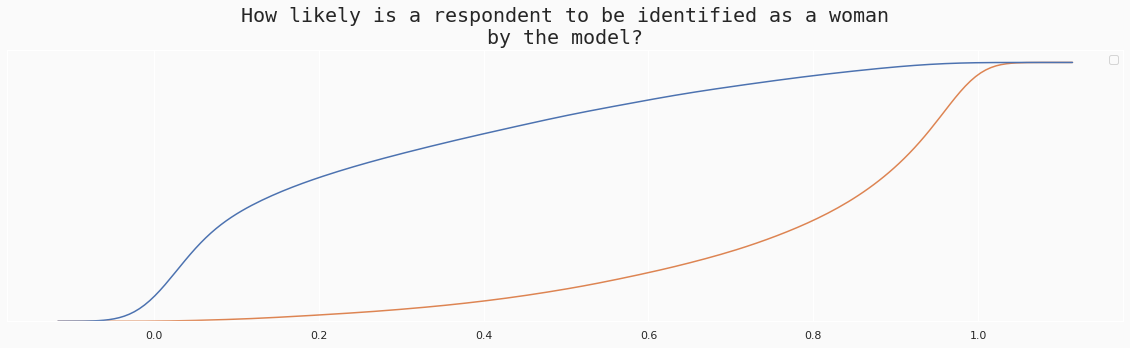

In [34]:
data_women = results.query('actuals == 1').preds_LGBMClassifier
data_men = results.query('actuals == 0').preds_LGBMClassifier

fig, ax = plt.subplots(1, 1, figsize=(20,5))
ax.set_facecolor('#fafafa')
sns.kdeplot(
    data=results, x="preds_LGBMClassifier", hue="actuals",
    cumulative=True, common_norm=False, common_grid=True,
)

plt.legend()
plt.title('How likely is a respondent to be identified as a woman\nby the model?',
          fontfamily='monospace',
          fontsize=20)
ymin, ymax = plt.ylim()
#plt.vlines(x=0.50,ymax=ymin, ymin=ymax, color='red')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticks([])

In [35]:
results = results.join(df['age'], how='left')

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.920


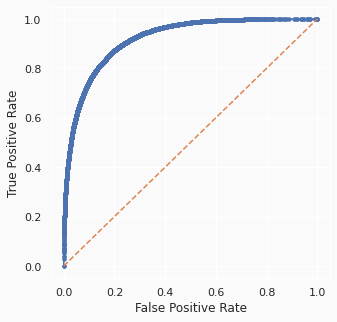

In [36]:
ns_probs = [0 for _ in range(len(y_test))]

fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.set_facecolor('#fafafa')
# calculate scores
for model in models:
    probs = model.predict_proba(X_test)[:, 1]
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, probs)
    ax.plot(lr_fpr, lr_tpr, marker='.', label=model.__class__.__name__)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
ax.get_legend().remove()
ax.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.savefig('../figures/roc-auc.svg', format='svg')

In [37]:
movies = pd.read_csv('../data/title.basics.tsv', sep='\t')

movies = movies[movies.genres.notnull()]
movies = movies[movies.startYear != '\\N']
movies.startYear = movies.startYear.astype(int)
movies['is_romance'] = movies.genres.str.contains('Romance')
movies.shape

movies.head()

Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,is_romance
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",False
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short",False
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance",True
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short",False
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short",False


Text(0.5, 1.0, 'How Many Romance Movies Were Released This Year? (1950-)')

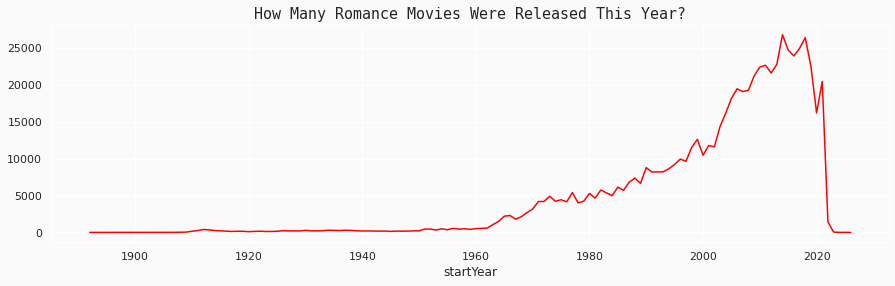

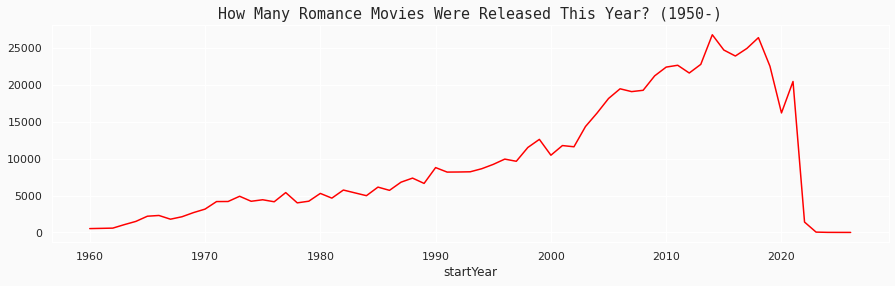

In [38]:
plt.figure(figsize=(15,4))
movies[movies.is_romance]\
    .groupby('startYear').count().primaryTitle\
    .plot(color='red')
plt.title('How Many Romance Movies Were Released This Year?', fontsize=15, fontfamily='monospace')

plt.figure(figsize=(15,4))
movies[movies.is_romance]\
    .groupby('startYear').count().primaryTitle\
    .loc[1960:]\
    .plot(color='red')
plt.title('How Many Romance Movies Were Released This Year? (1950-)', fontsize=15, fontfamily='monospace')

In [39]:
movies.groupby(['startYear', 'is_romance']).count().primaryTitle

startYear  is_romance
1874       False          1
1877       False          4
1878       False          2
1881       False          2
1882       False          2
                         ..
2025       True           3
2026       False         15
           True           1
2027       False         14
2028       False          3
Name: primaryTitle, Length: 281, dtype: int64

## Feature Importances

In [40]:
shap.initjs()

In [41]:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [42]:
# High prob of a woman - 7336
row = results.reset_index()\
    .query('preds_LGBMClassifier < 0.1')\
    .sample(1)
i = row.index[0]
print(row)
shap.force_plot(explainer.expected_value[1], shap_values[1][i,:], X_test.iloc[i,:],
               plot_cmap=[COLOR_FEMALE, COLOR_MALE])


      index  actuals  preds_LGBMClassifier  age
9226  98198        0              0.054653   25


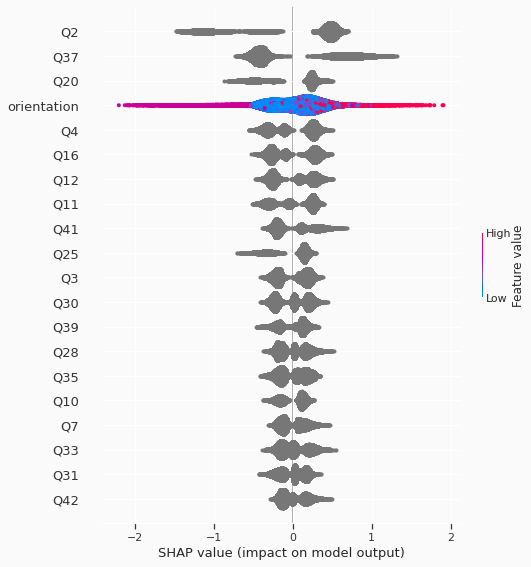

In [43]:
shap.summary_plot(shap_values[1], X_test,show=False)
#plt.savefig('../figures/shap-summary.svg', format='svg')

In [50]:
X_test.orientation.value_counts()

1    32337
2    13206
3     5907
5     2852
4     2536
0      802
Name: orientation, dtype: int64

<AxesSubplot:>

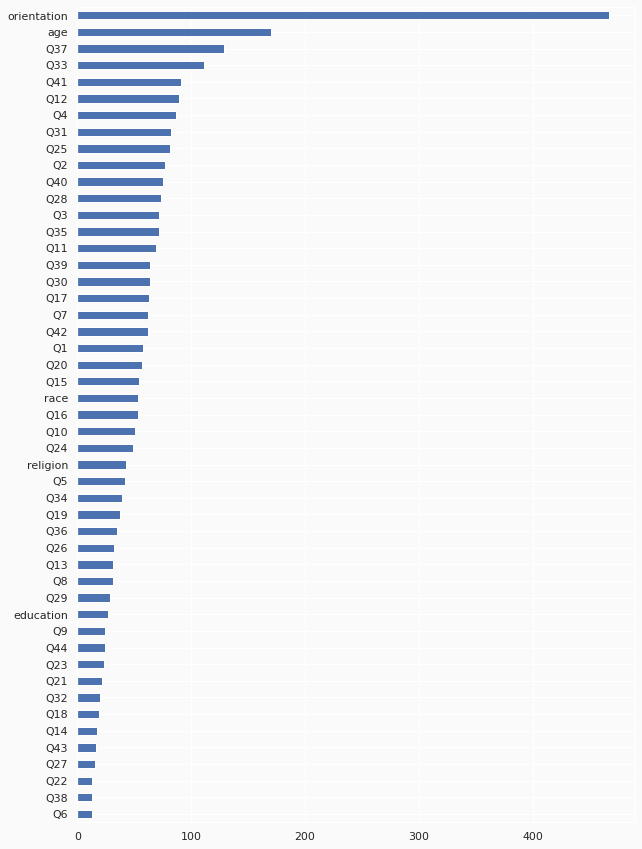

In [49]:
plt.figure(figsize=(10,15))
pd.Series(lgbm.feature_importances_, index=X_test.columns)\
    .sort_values()\
    .plot.barh()

## Non-Binary People

In [50]:
data = df.copy()

data['is_nb'] = (data.gender == 'Other').astype(int)
data = data.drop(['gender'], axis=1)

Y_LABEL= 'is_nb'
temp1 = data[[*QUESTION_COLS, Y_LABEL]]#.iloc[:100000]

y = temp1[Y_LABEL]
X = temp1.drop(Y_LABEL, axis=1).applymap(lambda x: 1 if x == 'Agree' else 0)

In [51]:
y.value_counts() / len(y)

0    0.917392
1    0.082608
Name: is_nb, dtype: float64

In [52]:
from imblearn.over_sampling import SMOTE

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y)

X_train, y_train = SMOTE().fit_resample(X_train, y_train)

lgbm = LGBMClassifier(max_depth=10, colsample_bytree=0.7)
models = [lgbm]

for model in tqdm(models):
    model.fit(X_train, y_train)
    
results = pd.DataFrame({'actuals': y_test})
metrics = dict()

for model in tqdm(models):
    results[f'preds_{model.__class__.__name__}'] = model.predict_proba(X_test)[:, 1]
    preds = (results[f'preds_{model.__class__.__name__}'] >= 0.50).astype(int)
    metrics[model.__class__.__name__] = dict()
    for metric in [precision_score, recall_score, roc_auc_score, accuracy_score, f1_score]:
        metrics[model.__class__.__name__][metric.__name__] = metric(results.actuals, preds)
        
metrics = pd.DataFrame(metrics).T
metrics

100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.96it/s]


,accuracy_score,f1_score,precision_score,recall_score,roc_auc_score
LGBMClassifier,0.712176,0.22909,0.147088,0.517726,0.623705


[]

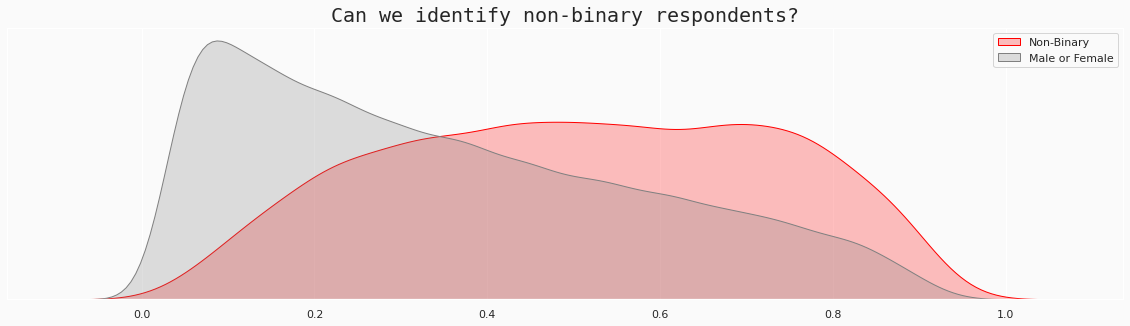

In [54]:
data_nb = results.query('actuals == 1').preds_LGBMClassifier
data_b = results.query('actuals == 0').preds_LGBMClassifier

fig, ax = plt.subplots(1, 1, figsize=(20,5))
ax.set_facecolor('#fafafa')
sns.kdeplot(data_nb, fill=True, label='Non-Binary', ax=ax, color='red')
sns.kdeplot(data_b, fill=True, label='Male or Female', ax=ax, color='grey')

plt.legend()
plt.title('Can we identify non-binary respondents?',
          fontfamily='monospace',
          fontsize=20)
ymin, ymax = plt.ylim()
#plt.vlines(x=0.50,ymax=ymin, ymin=ymax, color='red')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticks([])

In [55]:
y_resampled.shape

NameError: name 'y_resampled' is not defined

In [56]:
y.shape

(314148,)

<AxesSubplot:>

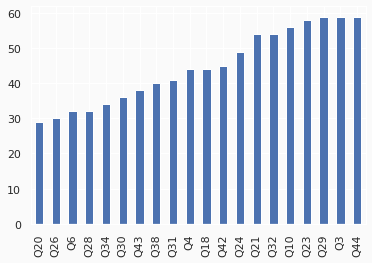

In [57]:
pd.Series(lgbm.feature_importances_, index=X_test.columns)\
    .sort_values().head(20).plot.bar()